# Data Analysis: CE Survey Reporting Rates

The Consumer Expenditure (CE) Survey collects data on expenditures made by consumer units (which I will refer to as households) across the United States. Two surveys are used to collect this data, the Quarterly Interview Survey (Interview) and the Diary Survey (Diary). The data is made public through the Public-Use Micro Data (PUMD) initiative, the homepage of which is <a href="https://www.bls.gov/cex/pumd.htm">here</a>.

I am going to keep it simple, but practical by calculating a proportion called a reporting rate. In this case, it is better referred to as an expense reporting rate, which is used to determine how likely a household is to report having made a certain expense over a defined time period.

An expense reporting rate for any item(s) is defined as the proportion of households that reported <i>at least one expense</i> for the item(s) to the total number of households <i>eligible to report an expense</i> for the item(s).

$$\text{Expense Reporting Rate} = \frac{\text{# Households Reported At Least One Expense}}{\text{# Households Eligible to Report an Expense}}$$

I will use data from the CE Interview survey to calculate the rate at which households report expenses for power and non-powered tools (chosen items are arbitrary). One could slice-and-dice this rate by all types of characteristics--race, sex, age, geographic location, tax bracket--but I will calculate the reporting rates by quarter.

## Consumer Expenditure Survey Files

The PUMD from the CE Interview can be found <a href="https://www.bls.gov/cex/pumd_data.htm">here</a> and I downloaded the 2016 data as SAS files. All available formats include data for the quarters 2016Q1 - 2017Q1.

### Part 1: At Least One Expenditure (Numerator)

According to the <a href="https://www.bls.gov/cex/capi/2015/cecapihome.htm">2016 Interview questionnaire</a>, expenses made on power tools and non-powered tools are reported in <a href="https://www.bls.gov/cex/capi/2015/csxsection6b.htm">Section 6, Part B</a>. The <a href="https://www.bls.gov/cex/2016/csxintvw.pdf">PUMD documentation on the 2016 Interview</a> (Section II. File Information) states that expenses reported in Section 6, Part B are stored in the APB file.

Below is the code for importing the APB file, stored in the data frame <code>apb_expn</code>.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
apb_expn = pd.read_sas(filepath_or_buffer='C:/Users/Barbieri/Desktop/Research and Education/CE Micro Data/apb16.sas7bdat',
                   format='sas7bdat',
                   encoding='latin-1')
apb_expn.head()

,QYEAR,NEWID,SEQNO,ALCNO,REC_ORIG,MINAPPLY,MINA_PLY,GFTCMIN,GFTCMIN_,MIN_MO,...,MNAPPL7_,MNAPPL8,MNAPPL8_,MNAPPL9,MNAPPL9_,INSTLSCR,INST_SCR,INSTLLEX,INST_LEX,TVPURCH
0,20161,03088744,1.0,0.0,1,460,D,3,D,12,...,A,NaN,A,NaN,A,NaN,A,NaN,A,NaN
1,20161,03088744,2.0,0.0,1,460,D,1,D,12,...,A,NaN,A,NaN,A,NaN,A,NaN,A,NaN
2,20161,03088894,1.0,0.0,1,470,D,3,D,12,...,A,NaN,A,NaN,A,NaN,A,NaN,A,NaN
3,20161,03088894,2.0,0.0,1,490,D,3,D,12,...,A,NaN,A,NaN,A,NaN,A,NaN,A,NaN
4,20161,03088954,1.0,0.0,1,640,D,1,D,12,...,A,NaN,A,NaN,A,2,D,NaN,A,NaN


#### Subset the Expenditure File

First, reduce the number of columns from 38 to 6. The variables QYEAR, NEWID, SECNO, ALCNO, define a unique record on the ABP file, also known as key variables. MINAPPLY is used to identify what item the reported expense was for.

In [3]:
apb_expn = apb_expn[['QYEAR','NEWID','SEQNO','ALCNO','MINAPPLY','MINPURX']]

apb_expn.head()

,QYEAR,NEWID,SEQNO,ALCNO,MINAPPLY,MINPURX
0,20161,03088744,1.0,0.0,460,212.0
1,20161,03088744,2.0,0.0,460,106.0
2,20161,03088894,1.0,0.0,470,20.0
3,20161,03088894,2.0,0.0,490,20.0
4,20161,03088954,1.0,0.0,640,100.0


Second, subset for the items of interest, power and non-powered tools. According to the <a href="https://www.bls.gov/cex/2016/csxintvwdata.pdf">2016 CE Interview data dictionary</a>, the item codes for power tools is "320" and non-powered tools is "330". The resulting data frame <code>expn_tools</code> has a row for every expense made on those items in all five quarters of interviewing.

For personal interest, I printed out the summary statistics using <code>describe</code>. The results show that generally households spend more purchasing powered tools than non-powered tool.

In [4]:
expn_tools = apb_expn[(apb_expn['MINAPPLY'] == '320') | (apb_expn['MINAPPLY'] == '330')]

expn_tools[['MINAPPLY','MINPURX']].groupby(['MINAPPLY']).describe()

MINPURX                                                         
           count        mean         std  min   25%    50%    75%     max
MINAPPLY                                                                 
320       1031.0  180.557711  248.427869  2.0  59.0  108.0  200.0  4000.0
330        718.0   69.901114   98.724092  1.0  20.0   39.5   83.0  1000.0

#### Numerator of the Expense Reporting Rate
Lastly, remember that the numerator is the number of households that report <i>at least one expense</i>. This means that households that report two expenses for powered tools should only count as one report in the numerator.

Explicitly, the frequency table below shows that there are several households that reported multiple expenses for powered or non-powered tools in a quarter.

In [5]:
expn_tools.groupby(['QYEAR','MINAPPLY'])['NEWID'].value_counts()[:5]

QYEAR  MINAPPLY  NEWID   
20161  320       03103584    5
                 03170824    5
                 03150504    4
                 03210033    3
                 03333981    3
Name: NEWID, dtype: int64

We will use <code>drop_duplicates</code> to remove duplicate expenditures by household for each MINAPPLY code (320 and 330).

In [6]:
expn_tools_nd = expn_tools.drop_duplicates(['QYEAR','MINAPPLY','NEWID'], inplace=False).reset_index(drop=True)
expn_tools_nd.head()

,QYEAR,NEWID,SEQNO,ALCNO,MINAPPLY,MINPURX
0,20161,03090494,2.0,0.0,320,50.0
1,20161,03090534,2.0,0.0,320,105.0
2,20161,03090724,2.0,0.0,320,150.0
3,20161,03092854,3.0,0.0,330,40.0
4,20161,03093294,2.0,0.0,330,50.0


After we have removed duplicates, we will end the section by calculating the frequency of households that reported at least one expense for the two items and store it in the data frame <code>expn_tools_aloe</code>.

In [7]:
expn_tools_aloe = expn_tools_nd.groupby(['QYEAR'])['MINAPPLY'].value_counts().reset_index(name='NUM_HH_ALOE')
expn_tools_aloe

,QYEAR,MINAPPLY,NUM_HH_ALOE
0,20161,320,205
1,20161,330,124
2,20162,320,170
3,20162,330,107
4,20163,320,205
5,20163,330,131
6,20164,320,181
7,20164,330,141
8,20171,320,176
9,20171,330,128


### Part 2: Total Eligible Households (Denominator)

Since all households are expected to answer every question in the CE Interview survey, all households are eligible to report expenditures on powered and non-powered tools. The family file, FMLY, contains one row per household for each quarter--QUARTER, NEWID are key variables. This survey design makes counting eligible households easy. All we have to do is import the FMLY file and count the number of households in each quarter.

The tricky part is that there is a FMLY file for each of the 5 quarters. I wrote a function <code>Count_Households</code> that imports each quarter's FMLY file and returns the quarter and a count of the number of households. The results are stored in a list <code>num_households_qtr</code>.

In [8]:
def Count_Households(file_name):
    quarters = []
    num_families = []
    
    for i in file_name:
        file = "C:/Users/Barbieri/Desktop/Research and Education/CE Micro Data/intrvw16/%s.sas7bdat" % i
        fmly = pd.read_sas(filepath_or_buffer=file,
                           format='sas7bdat',
                           encoding='latin-1')
        
        quarters.append('20' + i[4:7])
        num_families.append(len(fmly['NEWID']))
        
    return quarters, num_families

In [9]:
num_households_qtr = Count_Households(['fmli161x', 'fmli162','fmli163','fmli164','fmli171'])
num_households_qtr

(['20161', '20162', '20163', '20164', '20171'], [6426, 6342, 6372, 6301, 6208])

Let's store the list <code>num_households_qtr</code> in a data frame <code>df_num_households_qtr</code>. If one is interested in why I used the functions <code>list</code> and <code>zip</code>, then I suggest rerunning the command without them. It is important to understand how the function <code>DataFrame</code> interprets lists/arrays.

In [10]:
df_num_households_qtr = pd.DataFrame(data=list(zip(*num_households_qtr)), columns=['QYEAR', 'TOT_ELIG_FAM'])
df_num_households_qtr

,QYEAR,TOT_ELIG_FAM
0,20161,6426
1,20162,6342
2,20163,6372
3,20164,6301
4,20171,6208


### Part 3: Calculate Expense Reporting Rates

#### Merge

By combining the data frames <code>expn_tools_nd</code> and <code>df_num_households_qtr</code>, we will have one table <code>exp_rep_rates</code> with all of the components required to calculate reporting rates.

In [11]:
exp_rep_rates = expn_tools_aloe.merge(df_num_households_qtr, how='inner', on=['QYEAR'], sort=True)
exp_rep_rates

,QYEAR,MINAPPLY,NUM_HH_ALOE,TOT_ELIG_FAM
0,20161,320,205,6426
1,20161,330,124,6426
2,20162,320,170,6342
3,20162,330,107,6342
4,20163,320,205,6372
5,20163,330,131,6372
6,20164,320,181,6301
7,20164,330,141,6301
8,20171,320,176,6208
9,20171,330,128,6208


#### Calculate Reporting Rates

Calculate the expense reporting rate for the two items by dividing the number of households that reported at least one expenditure by the total number of households eligible to report an expenditure.

In [12]:
exp_rep_rates['EXP_REP_RATES'] = exp_rep_rates['NUM_HH_ALOE'] / exp_rep_rates['TOT_ELIG_FAM']
exp_rep_rates

,QYEAR,MINAPPLY,NUM_HH_ALOE,TOT_ELIG_FAM,EXP_REP_RATES
0,20161,320,205,6426,0.031902
1,20161,330,124,6426,0.019297
2,20162,320,170,6342,0.026805
3,20162,330,107,6342,0.016872
4,20163,320,205,6372,0.032172
5,20163,330,131,6372,0.020559
6,20164,320,181,6301,0.028726
7,20164,330,141,6301,0.022377
8,20171,320,176,6208,0.028351
9,20171,330,128,6208,0.020619


#### Plot Reporting Rates

Lastly, we can see that item reporting rates are higher for power tools (320) than non-powered tools (330).

MINAPPLY
320    AxesSubplot(0.125,0.125;0.775x0.755)
330    AxesSubplot(0.125,0.125;0.775x0.755)
Name: EXP_REP_RATES, dtype: object

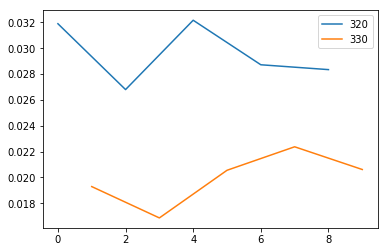

In [13]:
exp_rep_rates.groupby(['MINAPPLY'])['EXP_REP_RATES'].plot(kind='line', legend=True)